<a href="https://colab.research.google.com/github/geovannyAvelar/Analise_eleicoes_2020_covid/blob/main/An%C3%A1lise_elei%C3%A7%C3%B5es_municipais_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import seaborn as sns

# Preparação dos dados

Aqui são carregados os dois *datasets*: um de prefeitos do estado de São Paulo e outro com os casos e mortes por COVID-19 pouco tempo antes da eleição.

A ideia é mesclar esses dois *datasets* de modo a avaliar o tratamento aplicado em relação à pandemia do coronavírus pelos prefeitos candidatos à reeleição, ou seja, avaliar as gestões correntes quanto ao combate ao vírus.

Aqui são selecionadas as colunas de interesse nos dois *datasets*, por fim eles são mesclados formando um *dataset* com os dados do prefeito, o nome da cidade e os dados do COVID naquela cidade.

In [3]:
candidatos = pd.read_csv('candidatos_sp.csv')
candidatos = candidatos.query("ST_REELEICAO == 'S'")
candidatos = candidatos.iloc[:,1:-2]
candidatos = candidatos.rename(columns = {"NM_UE": "municipio", "NM_PARTIDO": "partido", "DS_GENERO": 'genero_prefeito', "NR_IDADE_DATA_POSSE": "idade_prefeito", "DS_GRAU_INSTRUCAO": "escolaridade", "DS_COR_RACA": "raca_prefeito", "DS_OCUPACAO": "profissao"})
candidatos = candidatos.drop(columns = ['DS_CARGO', 'DS_NACIONALIDADE'])

In [4]:
dados_covid = pd.read_csv('Dados-covid-19-municipios.csv', sep = ";", encoding = "ISO-8859-1")
dados_covid = dados_covid.iloc[:-1,2:5]
dados_covid = dados_covid.rename(columns = {"Município": "municipio", "Mun_Total de casos": "casos", "Mun_Total de óbitos": "mortes"})
dados_covid['municipio'] = dados_covid['municipio'].apply(lambda m: m.upper())

In [5]:
dataset = pd.DataFrame()

for candidato in candidatos.iterrows():
  busca_municipio = dados_covid[dados_covid['municipio'] == candidato[1]['municipio']]
  merge = pd.concat([busca_municipio.reset_index(), pd.DataFrame(candidato[1]).transpose().reset_index()], axis = 1)
  dataset = pd.concat([dataset, merge])

dataset = dataset.loc[:,~dataset.columns.duplicated()]
dataset.drop(columns = ['index'], inplace = True)
dataset.reset_index(drop = True, inplace = True)
dataset['idade_prefeito'] = dataset['idade_prefeito'].astype(int)
dataset['taxa_mortalidade'] = (dataset['mortes'] * 100) / dataset['casos']

# Análise exploratória

## Os dez partidos com mais candidatos à reeleição no estado de São Paulo

Como já era esperado, o Partido da Social Democracia Brasileira (PSDB) conta com o maior número de candidatos à reeleição, com 79 prefeitos pleiteando um segundo mandato. É quase o triplo em relação ao segundo colocado, o Democratas (DEM), que tem trinta prefeitos.

In [6]:
frequencia_partidos = pd.DataFrame(dataset.value_counts('partido')).reset_index(drop = False)
frequencia_partidos.columns = ['Partido', 'Número de prefeitos']

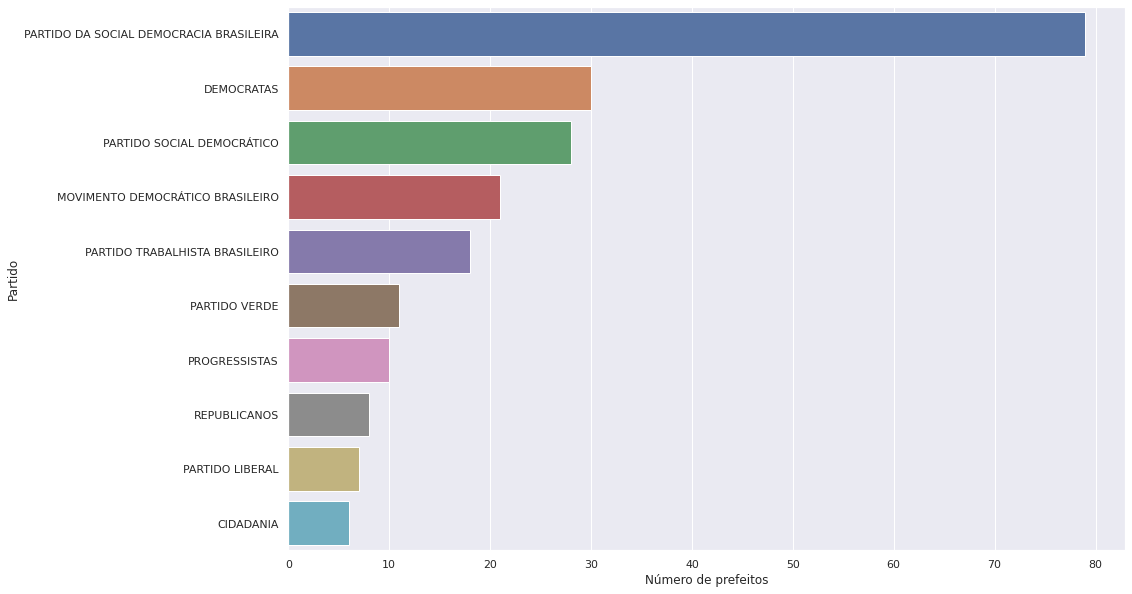

In [7]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.barplot(data = frequencia_partidos.head(10), x = 'Número de prefeitos', y = 'Partido')

## Escolaridade dos candidatos

A maior parte dos candidatos à reeleição possuem ensino superior completo.

In [8]:
frequencia_escolaridade = pd.DataFrame(dataset.value_counts('escolaridade')).reset_index(drop = False)
frequencia_escolaridade.columns = ['Escolaridade', 'Número de prefeitos']

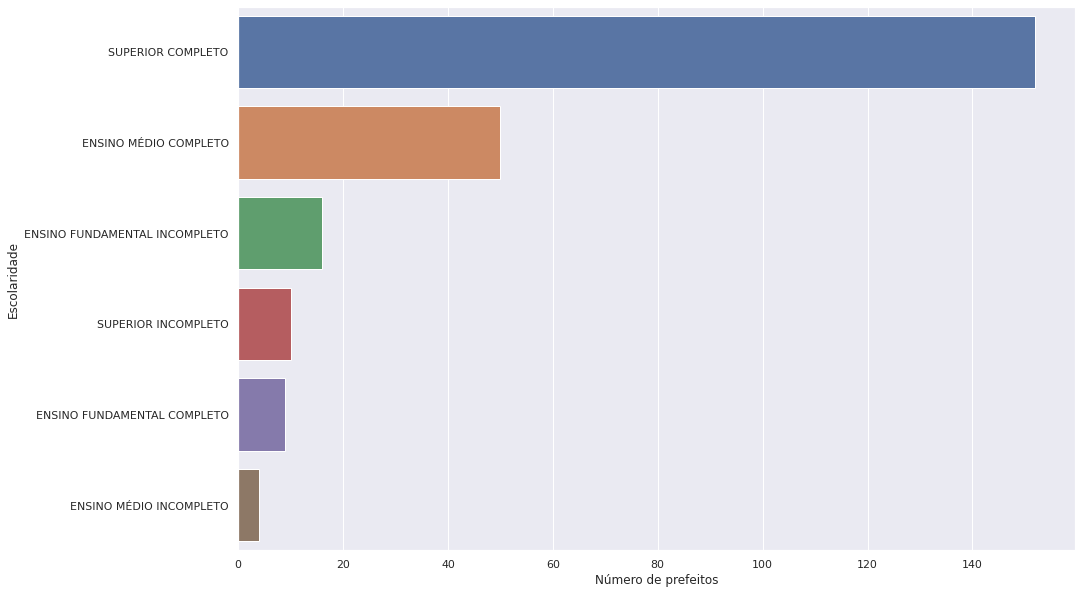

In [9]:
sns.barplot(data = frequencia_escolaridade.head(10), x = 'Número de prefeitos', y = 'Escolaridade')

## Raça e gênero

Dentre os candidatos à reeleição, a maioria esmagadora é de homens brancos. Das 237 cidades, são 209 prefeitos do gênero masculino e autodeclarados brancos. Há 18 mulheres brancas e nenhuma mulher negra.

In [10]:
raca_genero = pd.DataFrame(dataset.groupby(['raca_prefeito', 'genero_prefeito'])['municipio'].count()).reset_index(drop = False)
raca_genero.columns = ['raca', 'genero', 'frequencia']
raca_genero = raca_genero[raca_genero['raca'] != "SEM INFORMAÇÃO"]
raca_genero = pd.concat([raca_genero.apply(lambda x: x['raca'] + ' e ' + x['genero'], axis = 1), raca_genero['frequencia']], axis = 1)
raca_genero.columns = ['raca_genero', 'frequencia']

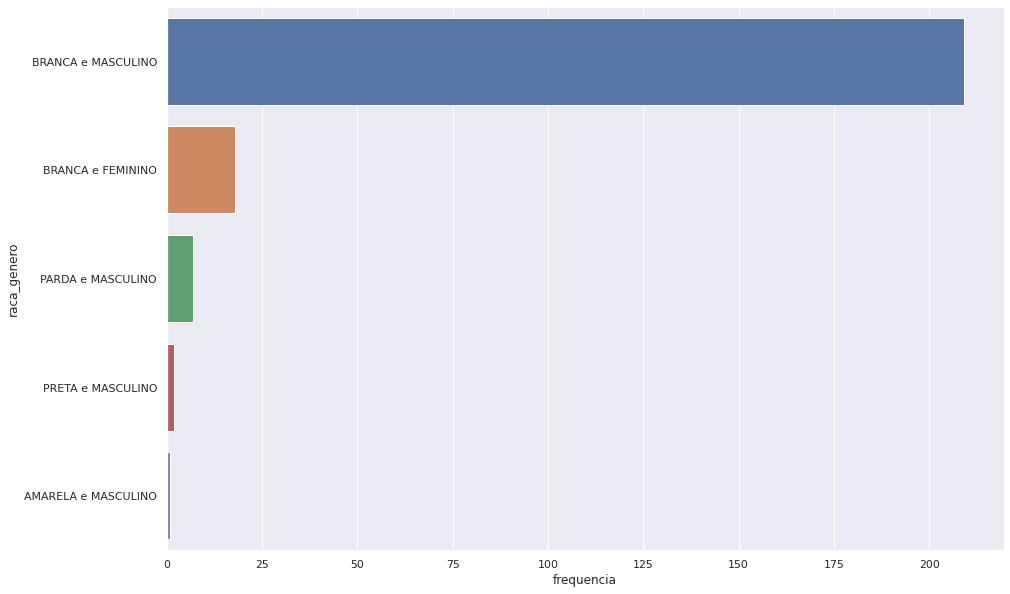

In [11]:
sns.barplot(data = raca_genero.sort_values('frequencia', ascending = False), x = 'frequencia', y = 'raca_genero')

## Profissão

A profissão mais comum entre os candidatos à reeleição é curiosamente a de...prefeito. O que demonstra que existe uma tendência a tratar a política como carreira. Na sequência vem a profissão de médico, seguido por empresário e agricultor.

In [12]:
profissoes = pd.DataFrame(dataset['profissao'].value_counts()).reset_index()
profissoes.columns = ['profissao', 'frequencia']

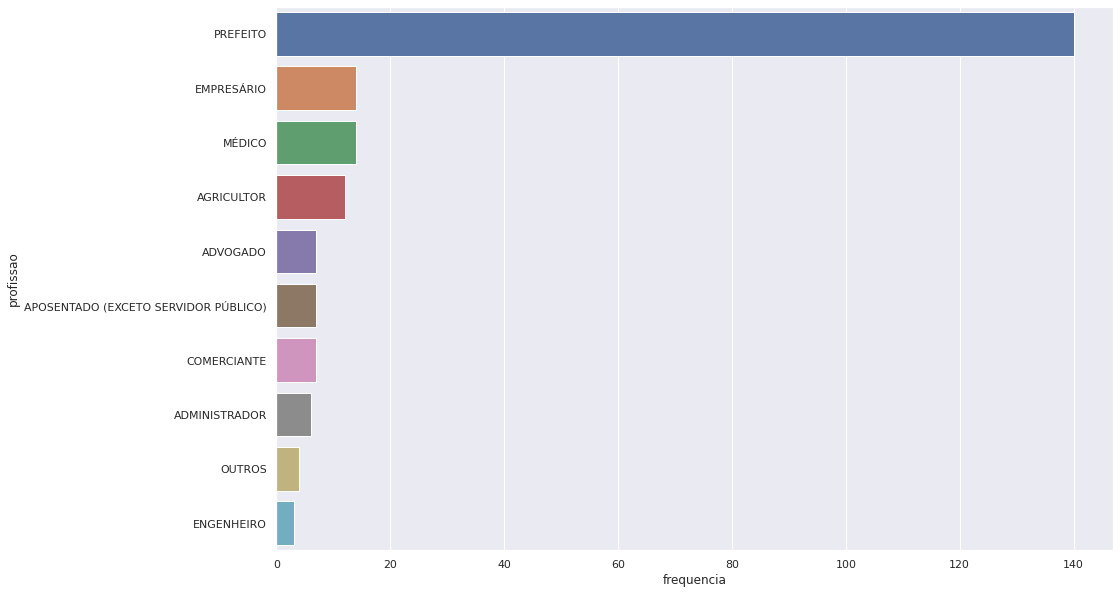

In [13]:
sns.barplot(data = profissoes.head(10), x = 'frequencia', y = 'profissao')

## Idade

Pelo diagrama de caixa é possível ver que a maioria dos prefeitos tem entre 45 e 60 anos, com a mediana em 53 anos. O perfil dos candidatos à reeleição no estado de São Paulo é então o de um homem branco de meia idade. O(a) prefeito(a) mais velho(a) tem 82 anos e o(a) mais jovem tem 27 anos de idade.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


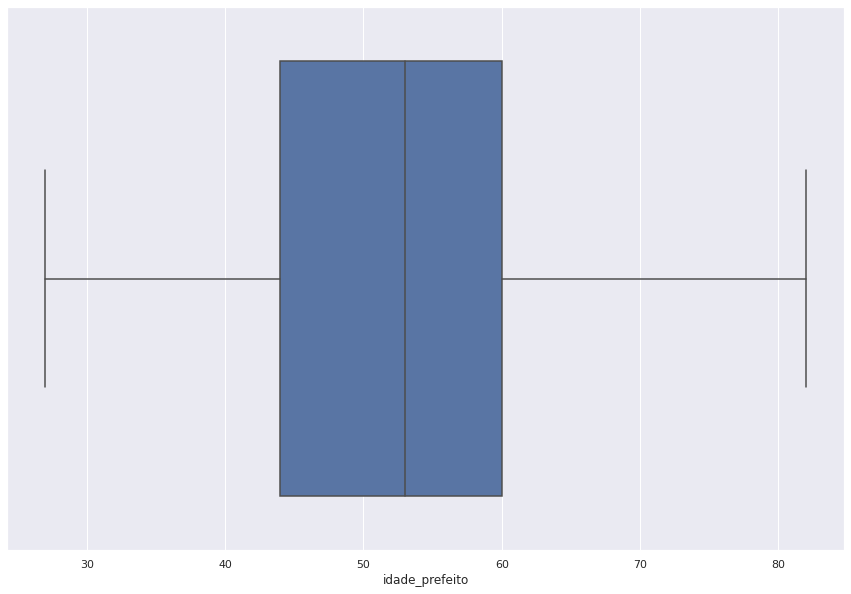

In [14]:
sns.boxplot(dataset['idade_prefeito'])

## Taxa de mortalidade por COVID


Esse é o diagrama de caixa representando a taxa de mortalidade de todos os municípios no conjunto de dados. A maior parte apresentou taxas entre 1.5% e 4%. Há valores aberrantes acima de 7%, provavelmente causados por cidades pequenas.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


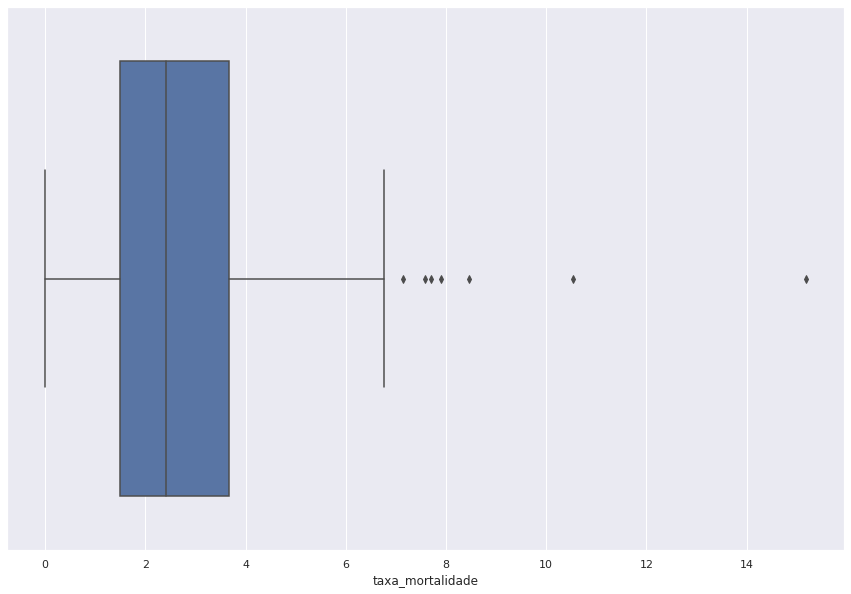

In [15]:
sns.boxplot(dataset['taxa_mortalidade'])

### Maiores taxas de mortalidade

Essas são as dez maiores taxas de mortalidade por COVID dentre os municípios em estudo. Lembrando que municípios pequenos causam distorções.

In [37]:
taxas_mortalidade = pd.DataFrame(dataset[['municipio', 'partido', 'profissao', 'taxa_mortalidade']].sort_values(by = 'taxa_mortalidade', ascending = False))

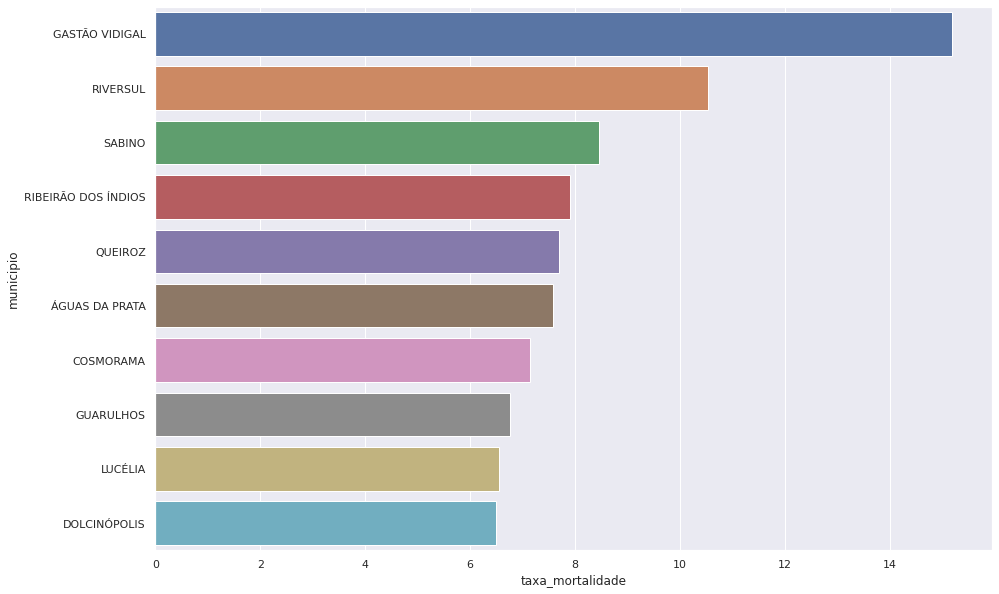

In [17]:
sns.barplot(data = taxas_mortalidade.head(10), x = 'taxa_mortalidade', y = 'municipio')

### Menores taxas de mortalidade

Essas são as menores taxas de mortalidade, excluindo municípios onde não houveram mortes.

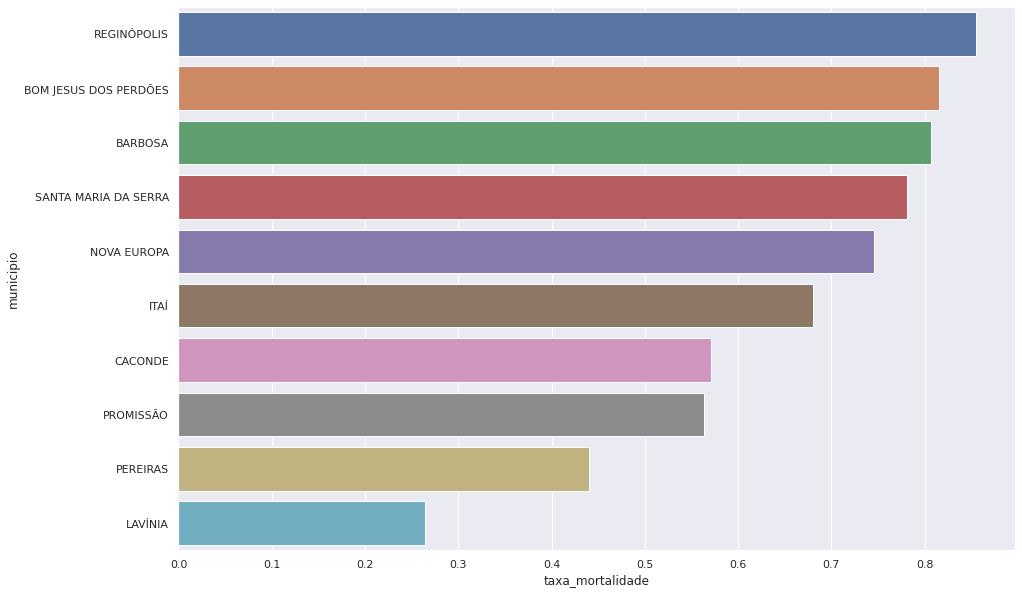

In [18]:
sns.barplot(data = taxas_mortalidade.query("taxa_mortalidade > 0").tail(10), x = 'taxa_mortalidade', y = 'municipio')

### Taxas de mortalidade mediana por partido

Aqui é possível ver as taxas de mortalidade mediana por partido. Essa análise por si só não indica que prefeitos desses partidos tiveram um tratamento pior ou melhor da pandemia, pois alguns são partidos pequenos demais para inferir qualquer coisa. Porém, é uma certa coincidência que partidos em sua maioria ideologicamente alinhados com políticos que negam a gravidade do vírus estejam com taxas medianas de mortalidade maiores.

In [32]:
taxa_mortalidade_mediana_partido = taxas_mortalidade.groupby('partido').median().sort_values(by = "taxa_mortalidade", ascending = False).reset_index()

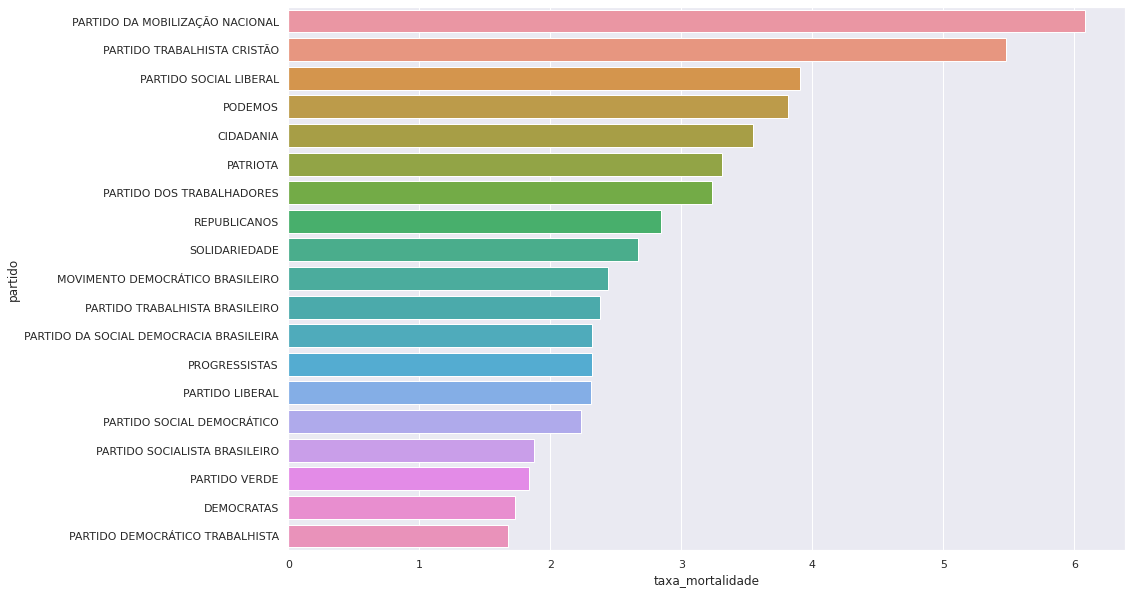

In [35]:
sns.barplot(data = taxa_mortalidade_mediana_partido, x = "taxa_mortalidade", y = "partido")

Esse é o diagrama de caixa representando as medianas das taxas de mortalidade de todos os partidos no conjunto de dados. A maior parte apresentou taxas entre 2.5% e 3.5%. Há dois valores aberrantes acima de 5%, que são o Partido da Mobilização Nacional (PMN) e o Partido Trabalhista Cristão (PTC), ambos partidos pequenos.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


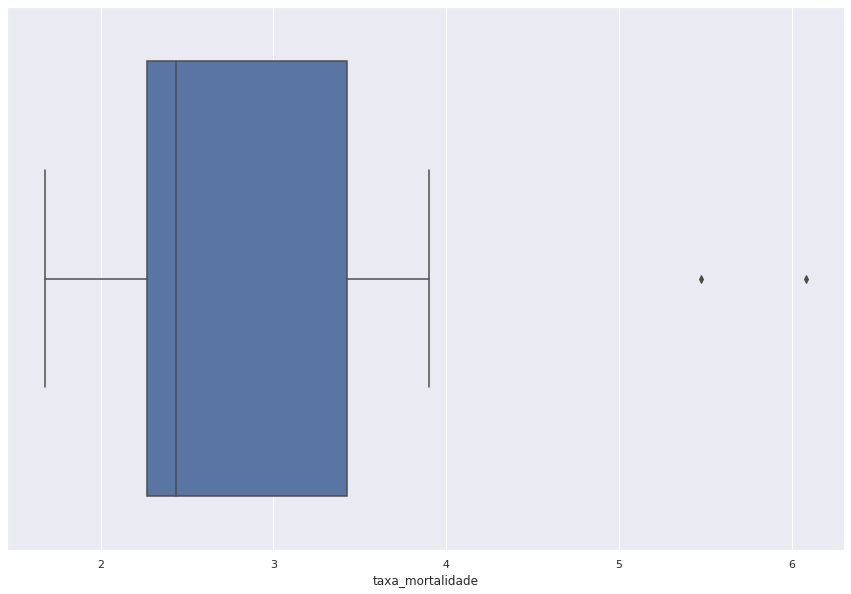

In [36]:
sns.boxplot(taxa_mortalidade_mediana_partido['taxa_mortalidade'])

### Taxas de mortalidade pela escolaridade do prefeito

Essa é uma pergunta interessante. Prefeitos com maior formação, por exemplo, fizeram algo que influenciasse a taxa de mortalidade por COVID em seus municípios? A resposta parece não. No gráfico não é possível notar nenhum padrão que indique alguma correlação. O índice de correlação é de apenas 0.11, o que indica que a correalção entre as duas variáveis é irrisória. Correlação não implica causa, mas para haver causa é necessário correlação, o que não se apresenta aqui.



In [46]:
dataset['escolaridade_encode'] = dataset['escolaridade'].replace({'ENSINO FUNDAMENTAL INCOMPLETO': 1, 'ENSINO FUNDAMENTAL COMPLETO': 2, 
                                                                  'ENSINO MÉDIO INCOMPLETO': 3, 'ENSINO MÉDIO COMPLETO': 4,
                                                                  'SUPERIOR INCOMPLETO': 5, 'SUPERIOR COMPLETO': 6})

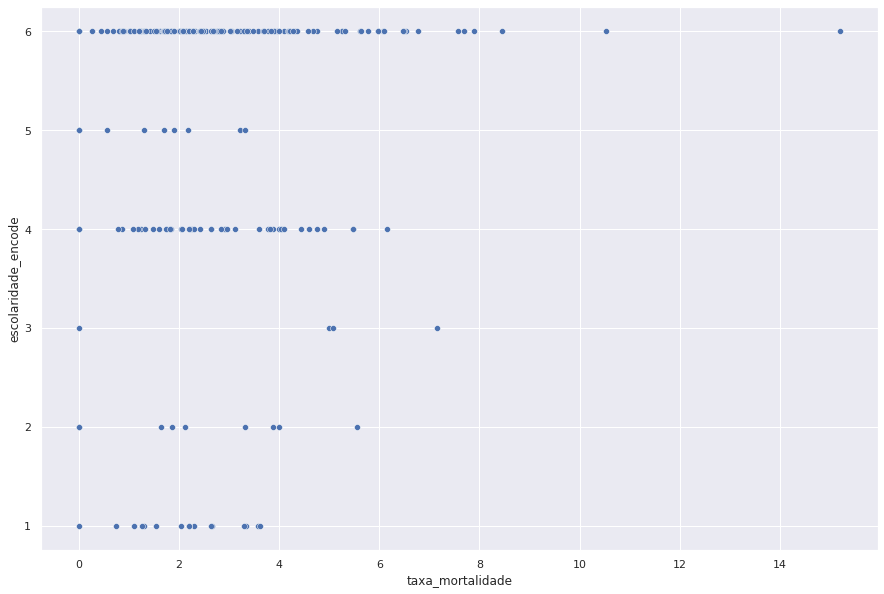

In [52]:
sns.scatterplot(data = dataset[['taxa_mortalidade', 'escolaridade_encode']], x = 'taxa_mortalidade', y = 'escolaridade_encode')

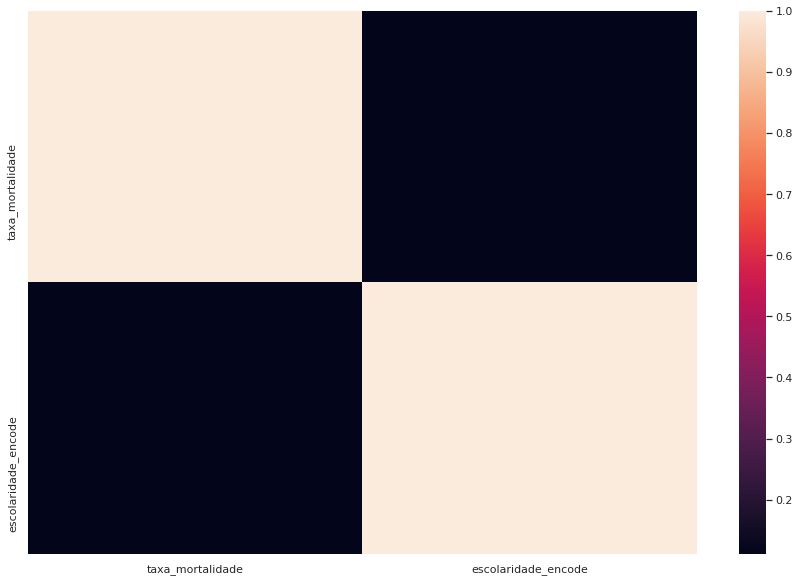

In [54]:
sns.heatmap(dataset[['taxa_mortalidade', 'escolaridade_encode']].corr())

### Taxas de mortalidade pela idade do prefeito

Um prefeito jovem seria mais 'mente aberta' quando o assunto é pandemia? Talvez sim, talvez não. Há uma leve correlação negativa (-0.23) entre a idade do prefeito e a taxa de mortalidade. É difícil comprovar a tese pois a correlação é baixa e não implica causa.

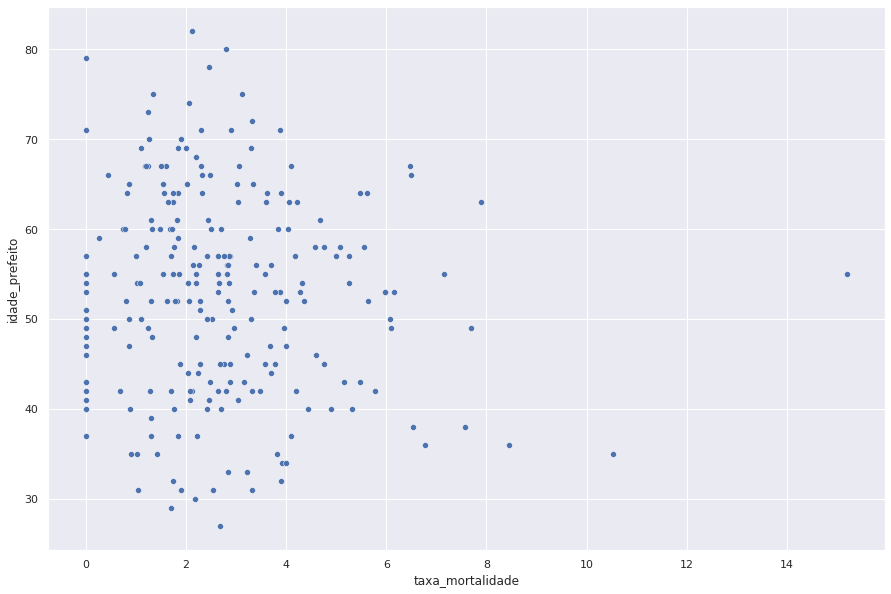

In [57]:
sns.scatterplot(data = dataset[['taxa_mortalidade', 'idade_prefeito']], x = 'taxa_mortalidade', y = 'idade_prefeito')

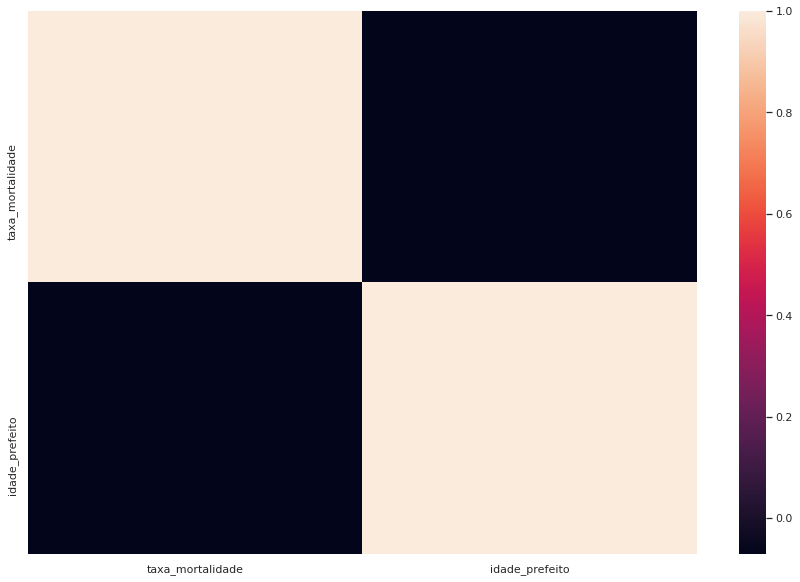

In [58]:
sns.heatmap(dataset[['taxa_mortalidade', 'idade_prefeito']].corr())

Essas análises não possuem grande rigor estatístico, mas levantam questões interessantes sobre o tratamento da pandemia por parte da classe política.